In [4]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

!pip install yfinance
import yfinance as yf

quotes = yf.download("TSLA", "2016-01-01", "2020-12-31")
prices = quotes["Adj Close"]

[*********************100%***********************]  1 of 1 completed


### №1 Estimate 95% VaR and ES via historical method.

In [45]:
#переходим к доходностям вот таким кодом.. он показывает simple, arifmetic returns
#log returns: np.log(prices).diff()
returns = prices.pct_change().dropna()


alpha = 0.95
VAR_95h = -returns.quantile(1 - alpha, interpolation = 'higher')
ES_95h = -returns[returns < -VAR_95h].mean()
print(VAR_95h, ES_95h)

#Если мы пишем ES <= Var, то интерполяция не нужна
#типа если представить в столбиках распределение, слева lower столбик справа higher
#и Var проходит между ними. и когда пишем interpolation = higher, значит выбираем higher столбик

0.04929487816484701 0.08120770975014478


### №2 Estimate 95% VaR and ES via delta-normal method.

In [46]:
alpha = 0.95

#считаем параметры этого "нормального" распределения (m, Q) - (мю, сигма)
params_normal_distribution = ss.norm.fit(returns)


#подставляем в уравнение VAR = m - Q*q95
#q95 = 1.645, это кодом: ss.norm.ppf(0.95)  <-- квантиль 95 (правый)
VAR_95n = -(params_normal_distribution[0] - 1.645*params_normal_distribution[1]) 

#подставляем в уравнение ES = m + Q/(a-1)* Ф^(-1)(q95)
#Ф^(-1)(q95) = 0.103, это кодом: ss.norm.pdf(ss.norm.ppf(0.05))  <-- пробит-функция (квантильная), то есть по оси У левый квантиль
ES_95n = -(params_normal_distribution[0] + 0.103*params_normal_distribution[1]/(alpha-1))


print(VAR_95n, ES_95n)

0.05715748629444092 0.07228078885848545


### №3 Let's assume that t-distribution more suitable. Calculate 95% t-distribution VaR and ES.

In [9]:
#Баллада о том нахуя эмпирическое распределение подгонять к известному:
# 1. чтобы брать бесконечное число наблюдений от параметрического распределения
# 2. чтобы легче считать Var, ES (через формулы там mu + std*q95)

params_t_distribution = ss.t.fit(returns)

# [0] 2.7125415806433146 - степени свободы
# [1] 0.0018028131844154815 - m 
# [2] 0.0215410497941238 - Q, сигма

fitted_dist = ss.t(*ss.t.fit(returns)) #это просто мы моделируем новые returns по Т-распределению хуй пойми зачем

#VAR можно считать двумя способами, либо:
# VAR_95t = ss.t.ppf(1 - alpha, *params_t_distribution), либо:
VAR_95t = -fitted_dist.ppf(1 - alpha)

#для ES нужно посчитать интеграл.. (ожидаемая площадь под хвостом слева)
fitted_dist = ss.t(*ss.t.fit(returns))

import scipy.integrate
ES_95t, _ = scipy.integrate.quad(
    lambda x: - x * fitted_dist.pdf(x) / (1 - alpha),
    - np.inf,
    VAR_95t,
    )

print(VAR_95t, ES_95t)

0.051158045529018016 0.06493650596478644


## Lets's compare these VARs

In [10]:
comparing = pd.DataFrame({'Var_HS_95': [VAR_95h], 
                          'Var_95n': [VAR_95n], 
                          'Var_95t': [VAR_95t]}) 

comparing

,Var_HS_95,Var_95n,Var_95t
0,0.049295,0.057157,0.051158


Try to compare with 99 quantile, calculate delta-normal VaR and ES using .ppf function. Add this information to table

### №4 Let's see how it would be look if we would estimate a 1 day ahead many-many times. Window = 252.

#### Метод скользящего окна — алгоритм трансформации, позволяющий сформировать из членов временного ряда набор данных, который может служить обучающим множеством для построения модели прогнозирования. Чем меньше, тем на меньшем количестве данных обучаем модель по сути! Прикол

In [12]:
#применяем функцию VaR_fun на интервал окна window_length, и окно скользит слева направо
def calc_VaR(returns, VaR_fun, window_length, VaR_level):
  return returns.rolling(window = window_length, closed = "left").apply(
      VaR_fun, kwargs = {"alpha": VaR_level},
  ).rename(VaR_fun.__name__)




#создаем функцию (VaR_fun) которая будет считать VAR для меняющейся выборки (исторического распределения)
def calculate_VaR_HS(returns, alpha):
  return - returns.quantile(1 - alpha, interpolation = 'higher')

VAR_HS = calc_VaR(returns, calculate_VaR_HS, 252, alpha)



#создаем функцию (VaR_fun) которая будет считать VAR для меняющейся выборки (нормального распределения)
def calculate_VaR_norm(returns, alpha):
    params_norm = ss.norm.fit(returns)
    return -ss.norm.ppf(1 - alpha, *params_norm)

VAR_norm = calc_VaR(returns, calculate_VaR_norm, window_length = 252, VaR_level = alpha)



#создаем функцию (VaR_fun) которая будет считать VAR для меняющейся выборки (Т-распределения)
def calculate_VaR_t(returns, alpha):
    params_t = ss.t.fit(returns)
    return -ss.t.ppf(1 - alpha, *params_t)

VAR_t = calc_VaR(returns, calculate_VaR_t,  window_length = 252, VaR_level = alpha)

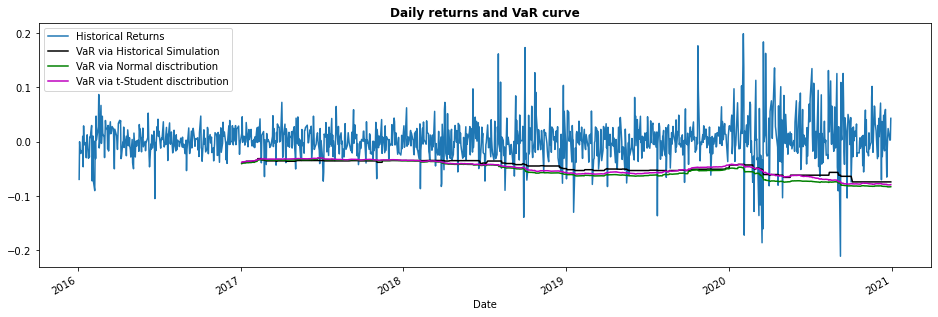

In [13]:
fig = plt.figure(figsize=(16, 5))
returns.plot()
(-VaR_HS).plot(color = "k")
(-VaR_norm).plot(color = "g")
(-VaR_t).plot(color = "m")
plt.title("Daily returns and VaR curve", weight = "bold")
plt.legend(
    [
        "Historical Returns",
        "VaR via Historical Simulation",
        "VaR via Normal disctribution",
        "VaR via t-Student disctribution",
    ]
)
plt.show()

## What would be changed if we use smaller window length = 30?

In [24]:
def calculate_VaR_HS(returns, alpha):
  return - returns.quantile(1 - alpha, interpolation = 'higher')
VaR_HS_smallerwindow = calc_VaR(returns, calculate_VaR_HS, 30, alpha)

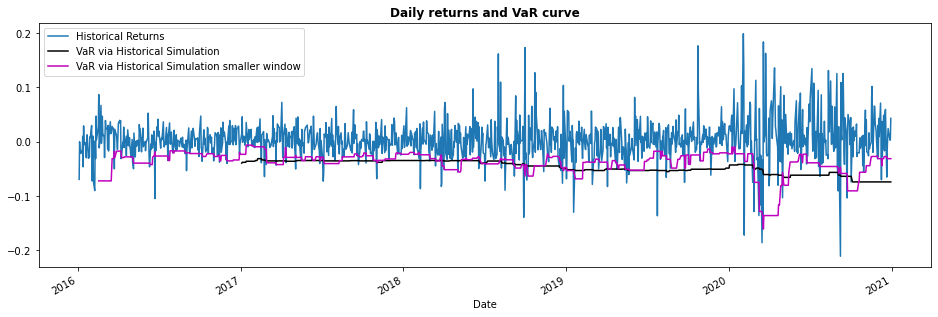

In [25]:
fig2 = plt.figure(figsize=(16, 5))
returns.plot()
(-VaR_HS).plot(color="k")
(-VaR_HS_smallerwindow).plot(color="m")
plt.title("Daily returns and VaR curve", weight="bold")
plt.legend(
    [
        "Historical Returns",
        "VaR via Historical Simulation",
        "VaR via Historical Simulation smaller window",
    ]
)
plt.show()

### №5 What does it look like for the generated distribution?

In [28]:
df = 3.5 #степени свободы

#фитим к Т-распределению с 3.5 степенями свободы
#лол 'mvsk' значит mean, var, skew, kurt, типа все параметры распределения просто считаем
mean, var, skew, kurt = ss.t.stats(df, moments = 'mvsk')

#x = np.linspace(ss.t.ppf(0.001, df), ss.t.ppf(0.999, df), 1000) <-- хуй знает че это значит

array(0.)

In [34]:
#rvs это типа set seed
sample = ss.t.rvs(df, size = 1000) #отобрали 1000 наблюдений из Т-распр с 3.5 степенями свободы, они теперь наши returns
returns = pd.Series(sample)

In [35]:
alpha = 0.999

def calculate_VAR_t(returns, alpha):
    params_t = ss.t.fit(returns)
    return -ss.t.ppf(1-alpha, *params_t)

VAR_t = calc_VaR(returns, calculate_VAR_t, 500, alpha)

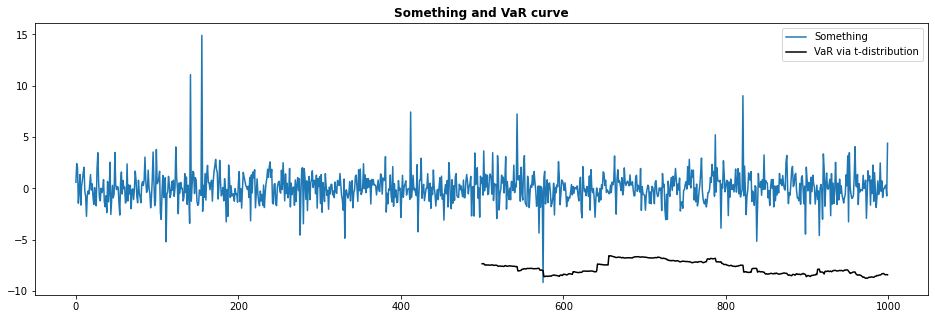

In [44]:
fig2 = plt.figure(figsize=(16, 5))
returns.plot()
(-VAR_t).plot(color="k")
plt.title("Something and VaR curve", weight="bold")
plt.legend(
    [
        "Something",
        "VaR via t-distribution",
    ]
)
plt.show()

In [ ]:
#хуй знает че это даст, как это отличается

def calc_VaR(returns, VaR_fun, window_length, VaR_level):
  VaR = np.full(returns.size, np.nan)

  for i in range(window_length, len(returns)):
    history = returns[i - window_length : i]
    VaR[i] = VaR_fun(history, VaR_level)

  return pd.Series(data=VaR, index=returns.index, name=VaR_fun.__name__)


VaR_t = calc_VaR(returns, calculate_VaR_t,  window_length=100, VaR_level=alpha)
VaR_t